In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from alpaca_trade_api import REST
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, StandardScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, confusion_matrix
from adquisición import get_data
import limpieza as l
from modelizacion import preparacion as p
from modelizacion import evaluar as e
import descarga_drive

# Adquisición de nuevos datos

Para la adquisicón de nuevos datos reutilizamos la función ***get_data*** del módulo de aquisición. En este caso fijamos la fecha de incio al ***10/12/2023*** para que luego, tras hacer la limpieza, nos queden datos posteriores al 22 de marzo de 2024

In [9]:
def adquisicion(symbols, start, api):
    get_data(symbols, start, api, 'raw_test')

In [10]:
symbols = ['AAPL', 'F', 'GOOG', 'META', 'MSFT', 'TSLA']
start = '2023-12-10'
api_key = 'PKQYAQ73E58SXZXCV500'
api_secret = '90vWP5CMCWHww9FeeIGGjMVZfP5T52WD7Xq7B3Il'
api = REST(key_id=api_key, secret_key=api_secret)

In [ ]:
# adquisicion(symbols, start, api)

# Limpieza de los nuevos datos

Para la limpieza y transformación de los nuevos datos reutilizamos las funciones que habíamos diseñado en el modulo de limpieza

In [11]:
def limpieza(symbols):
    descarga_drive.main('archivos_raw_test.txt')
    for s in symbols:
        df_s = pd.read_parquet(Path(Path.cwd(), f'data/raw_test_{s}.parquet'))
        df_trans = l.transform_df(df_s)
        l.process_news_sentiment(df_trans)
        df_sinnan = l.drop_na(df_trans)
        df_sinnan.to_parquet(f'./data/final_test_{s}.parquet')

In [ ]:
# limpieza(symbols)

In [ ]:
descarga_drive.main('archivos_final.txt')
descarga_drive.main('archivos_final_test.txt')

# Análisis de la deriva

Para hacer el estudio de los nuevos datos vamos a trabajar unicamente con las variables más importantes para los modelos y con la variable respuesta

In [12]:
best_models = {
    'AAPL': {'cols': ['Ret_3', 'VMA20', 'VMA_3ªsem', 'volatility_ui', 'trend_kst_diff', 'trend_adx', 'trend_aroon_up',
                          'momentum_pvo', 'others_dlr', 'volatility_bbli', 'volatility_kcli']},
    'F': {'cols': ['Rets', 'Ret_1', 'VMA20', 'VMA60', 'VMA_1ªsem', 'VMA_3ªsem', 'volume_em', 'volume_vpt',
                       'volatility_dcl', 'volatility_dcw', 'volatility_atr', 'trend_adx_pos', 'trend_visual_ichimoku_b',
                       'trend_aroon_down', 'trend_aroon_ind', 'momentum_uo', 'volatility_bbhi', 'volatility_bbli',
                       'trend_psar_up_indicator', 'trend_direction']},
    'GOOG': {'cols': ['Rets', 'Ret_1', 'Ret_2', 'Ret_3', 'VMA20', 'VMA60', 'VMA_2ªsem', 'VMA_4ªsem', 'VMA_5ªsem',
                          'volume_cmf', 'volume_em', 'volume_vpt', 'volatility_kcw', 'volatility_ui', 'trend_dpo',
                          'trend_adx', 'momentum_pvo', 'others_dlr']},
    'META': {'cols': ['Ret_2', 'volume_fi', 'volume_sma_em', 'volatility_dcw', 'trend_aroon_ind', 'momentum_ppo_hist',
                          'Rets^2', 'Ret_3^2', 'VMA40^2', 'VMA_5ªsem^2', 'volume_cmf^2', 'volume_em^2', 'volume_sma_em^2',
                          'volatility_dcw^2', 'momentum_ppo_hist^2', 'momentum_pvo_signal^2']},
    'MSFT': {'cols': ['VMA_2ªsem', 'volume_em', 'trend_adx_neg']},
    'TSLA': {'cols': ['Open', 'High', 'trend_psar_down_indicator', 'momentum_ppo_hist', 'Sent', 'trend_direction']},
}
cols = []
for k, v in best_models.items():
    cols += v['cols']
cols = pd.Series(cols).value_counts()
cols_analisis = list(cols[cols >= 2].drop(['VMA20', 'Ret_3', 'Ret_2', 'VMA_2ªsem', 'VMA60', 'Ret_1', 'VMA_3ªsem']).index)
cols_analisis

['volume_em',
 'Rets',
 'trend_direction',
 'volatility_dcw',
 'volume_vpt',
 'volatility_bbli',
 'others_dlr',
 'momentum_pvo',
 'trend_adx',
 'momentum_ppo_hist',
 'volatility_ui',
 'trend_aroon_ind']

Estas son las 12 variables más importantes para los modelos seleccionados. Hemos eliminado todas estas: 'VMA20', 'Ret_3', 'Ret_2', 'VMA_2ªsem', 'VMA60', 'Ret_1', 'VMA_3ªsem' pq se calculan a partir de Rets y tienen mucho que ver con rets.

Comparamos la distribución antigua y la nueva de estas 12 variables. Para los datos antiguos usamos todos los datos

Archivo final_AAPL.parquet guardado en: C:\Users\hecto\UNI\2\PDI\MBA-Finance\data\final_AAPL.parquet
Archivo final_F.parquet guardado en: C:\Users\hecto\UNI\2\PDI\MBA-Finance\data\final_F.parquet
Archivo final_GOOG.parquet guardado en: C:\Users\hecto\UNI\2\PDI\MBA-Finance\data\final_GOOG.parquet
Archivo final_META.parquet guardado en: C:\Users\hecto\UNI\2\PDI\MBA-Finance\data\final_META.parquet
Archivo final_MSFT.parquet guardado en: C:\Users\hecto\UNI\2\PDI\MBA-Finance\data\final_MSFT.parquet
Archivo final_TSLA.parquet guardado en: C:\Users\hecto\UNI\2\PDI\MBA-Finance\data\final_TSLA.parquet
Archivo datos_final.parquet guardado en: C:\Users\hecto\UNI\2\PDI\MBA-Finance\data\datos_final.parquet
Archivo final_test_AAPL.parquet guardado en: C:\Users\hecto\UNI\2\PDI\MBA-Finance\data\final_test_AAPL.parquet
Archivo final_test_F.parquet guardado en: C:\Users\hecto\UNI\2\PDI\MBA-Finance\data\final_test_F.parquet
Archivo final_test_GOOG.parquet guardado en: C:\Users\hecto\UNI\2\PDI\MBA-Finance

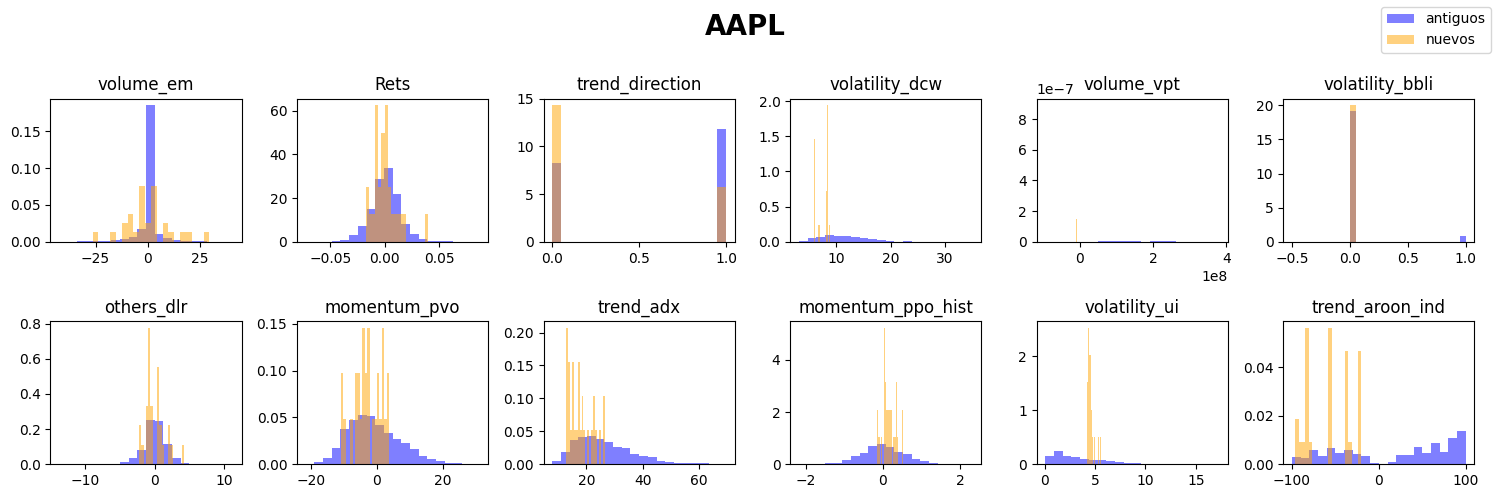

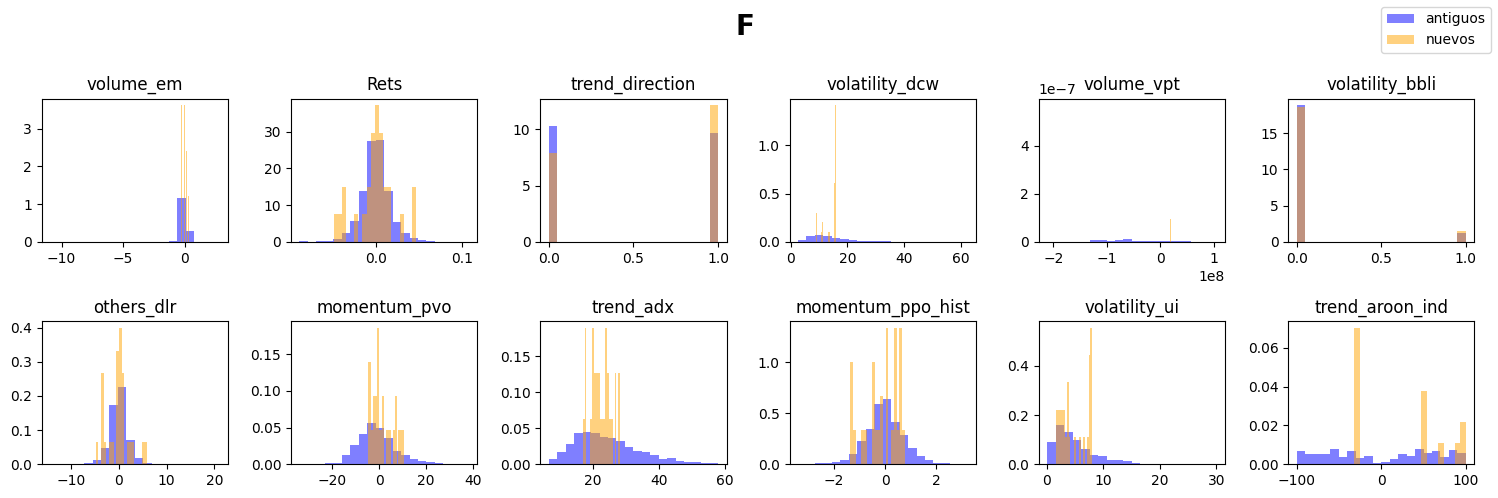

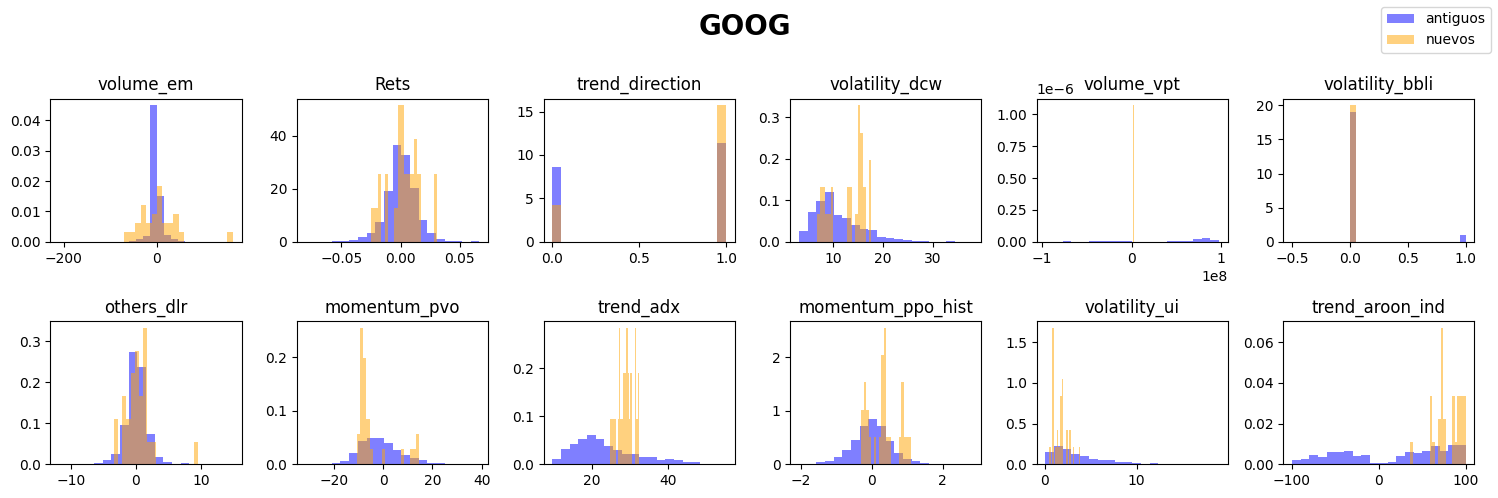

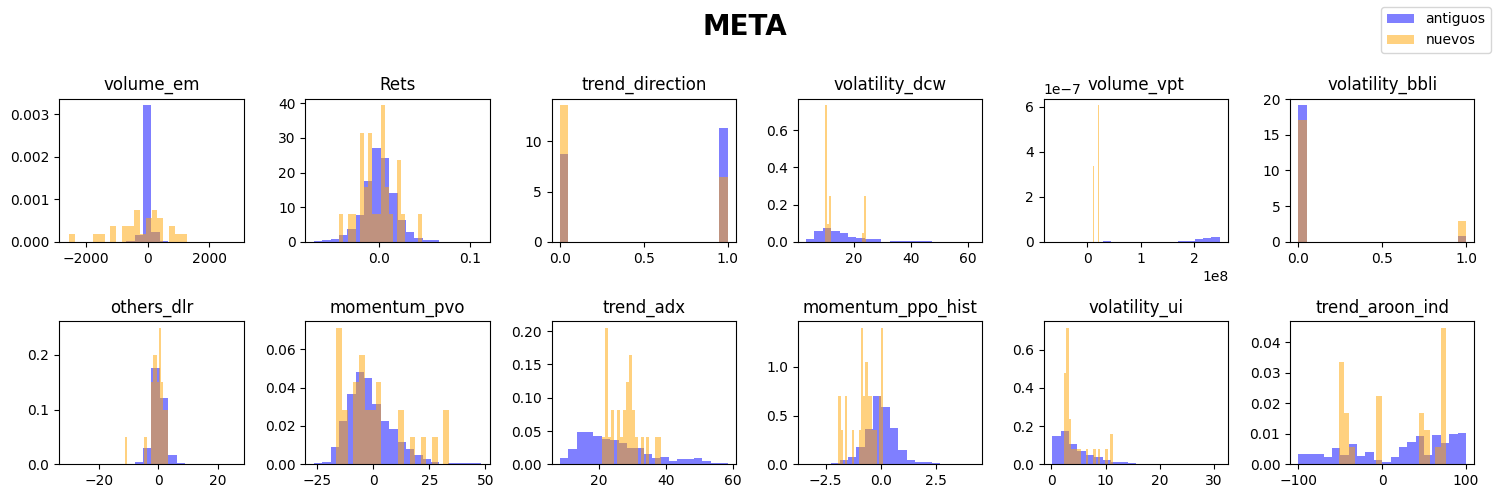

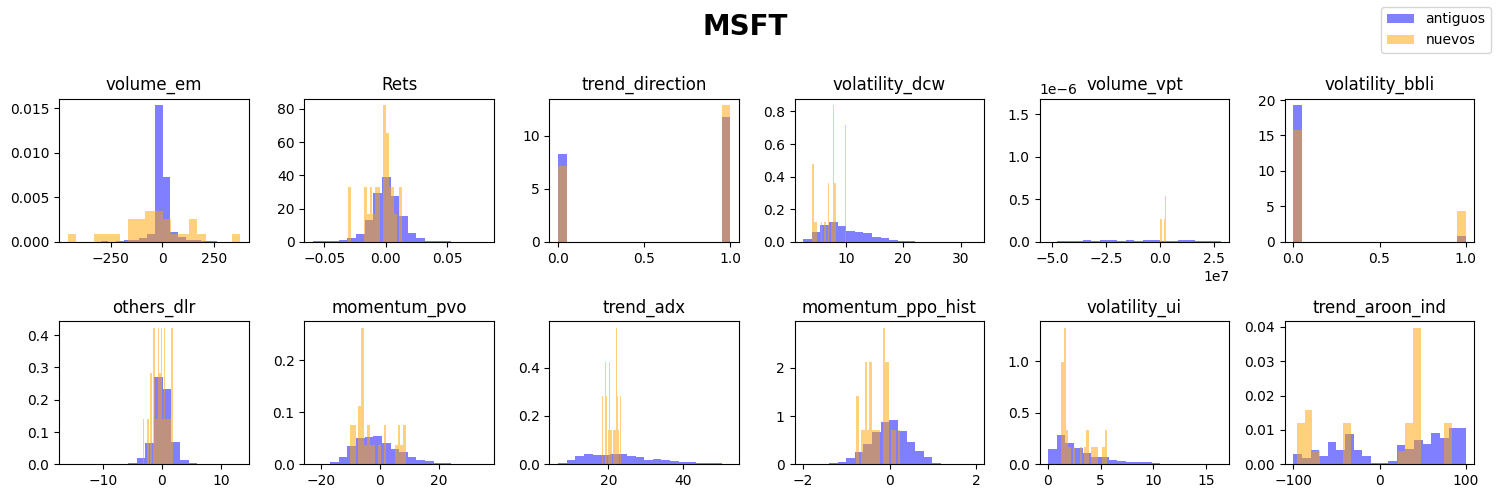

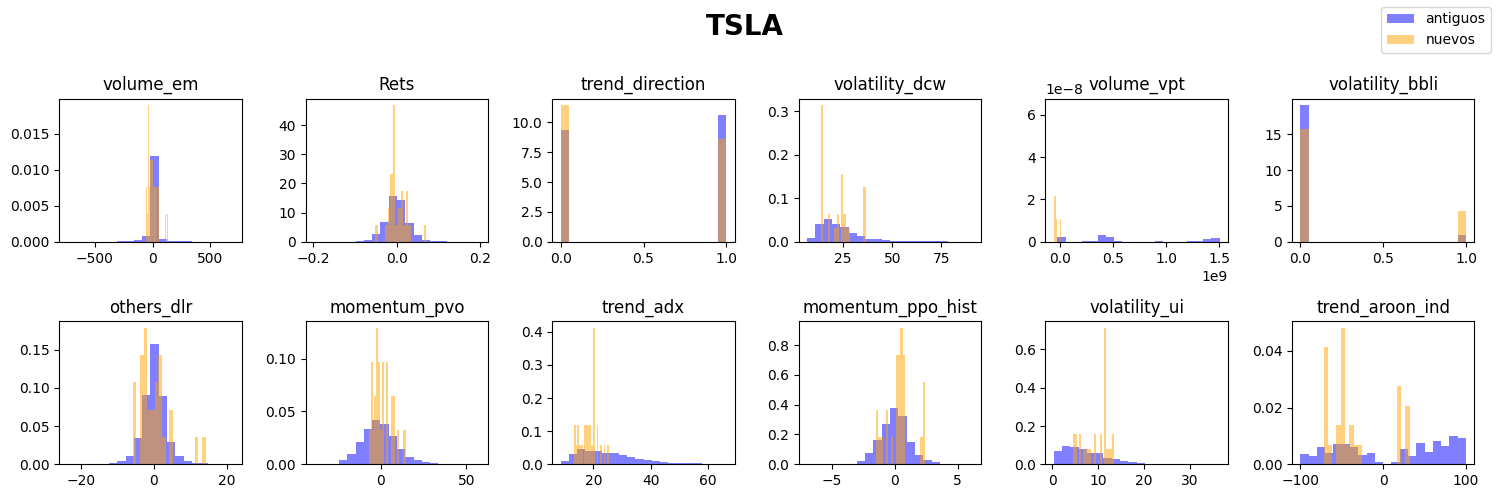

In [16]:
for s in symbols:
    fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(15, 5))
    i, j = 0, 0
    df = pd.read_parquet(f'data/final_{s}.parquet')
    df_nuevo = pd.read_parquet(f'data/final_test_{s}.parquet')
    for c in cols_analisis:
        axes[i, j].hist(df[c], alpha=0.5, color='blue', density=True, bins=20, label='antiguos')
        axes[i, j].hist(df_nuevo[c], alpha=0.5, color='orange', density=True, bins=20, label='nuevos')
        axes[i, j].set_title(c)
        j += 1
        if j == 6:
            i += 1
            j = 0
    fig.suptitle(s, fontsize=20, fontweight='bold')
    fig.legend(['antiguos', 'nuevos'], loc='upper right')
    plt.tight_layout()
    plt.show()

Vemos que las distribuciones son muy distintas. Esto se debe a que una distribución tiene información de 14 años y la otra de 30 días. Obviamente las observaciones de 30 días no representan a toda la variable. Para ver mejor como es la deriva de las variable predictoras con el paso del tiempo vamos a comparar las variables con ventanas temporales de 2 años.

Para hacer este análisis, como es más exhaustivo, de las 12 variables nos vamos a quedar unicamente con ***Rets, volume_em y trend_direction***

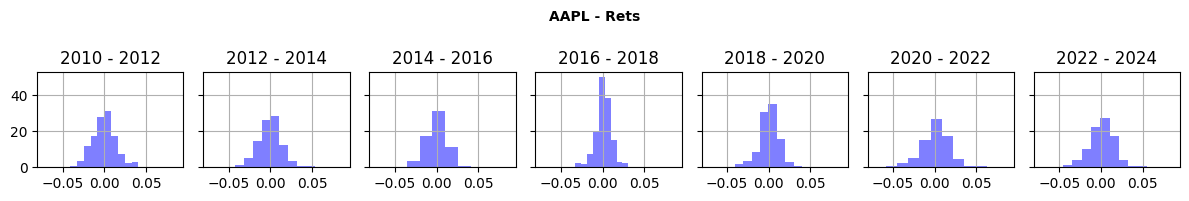

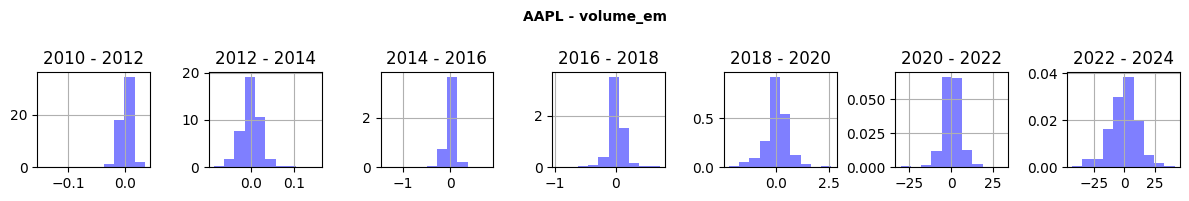

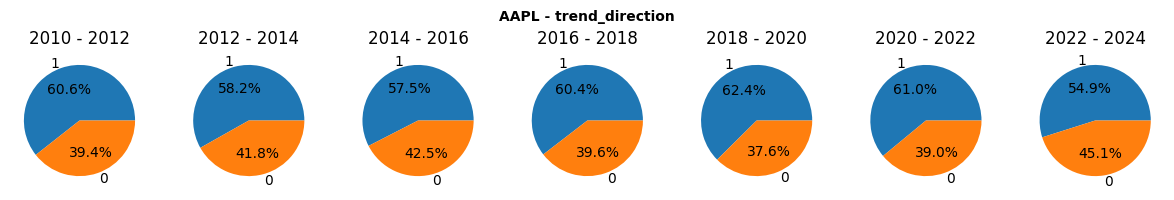

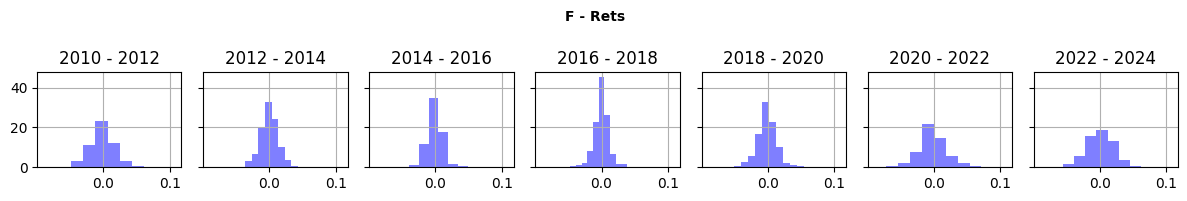

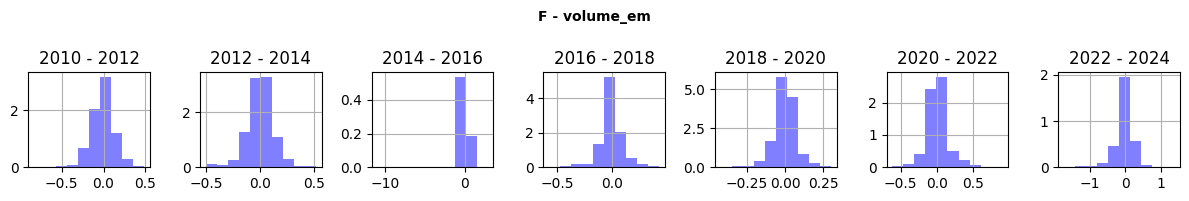

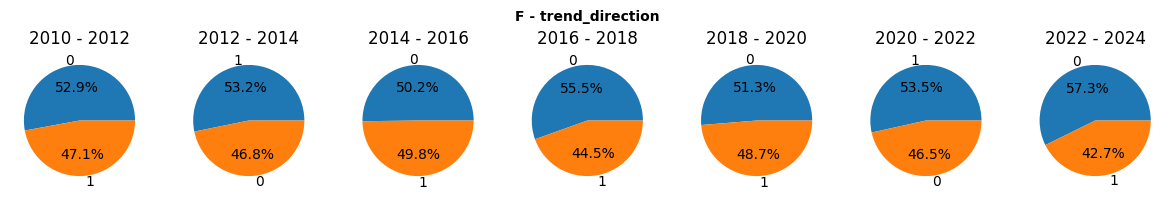

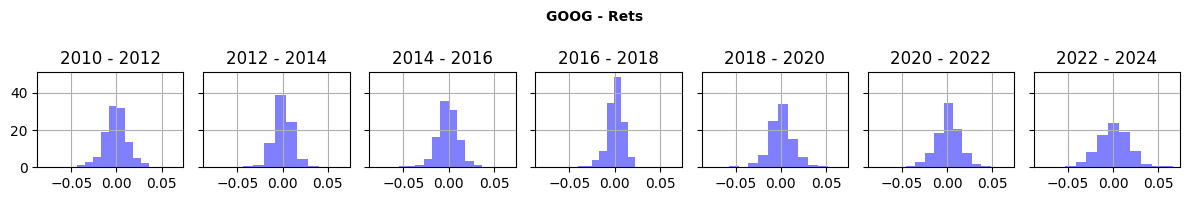

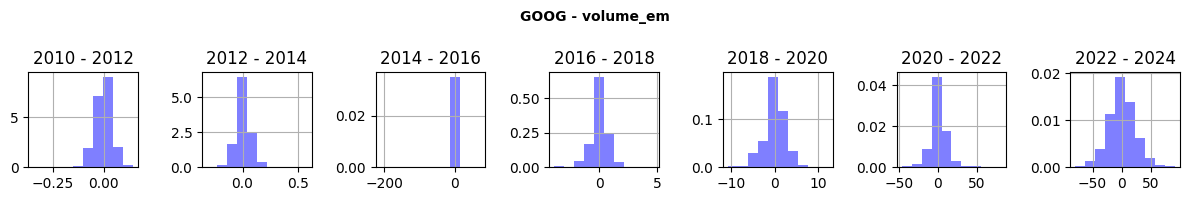

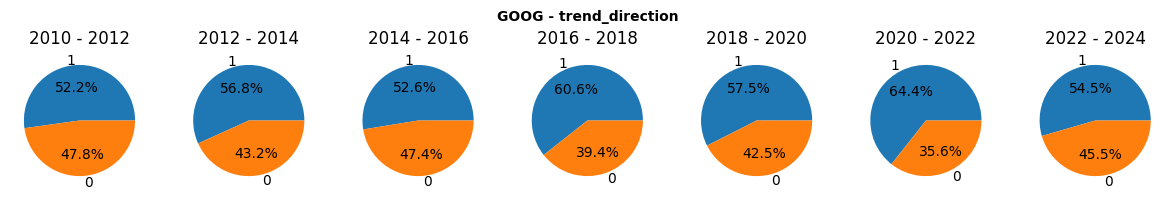

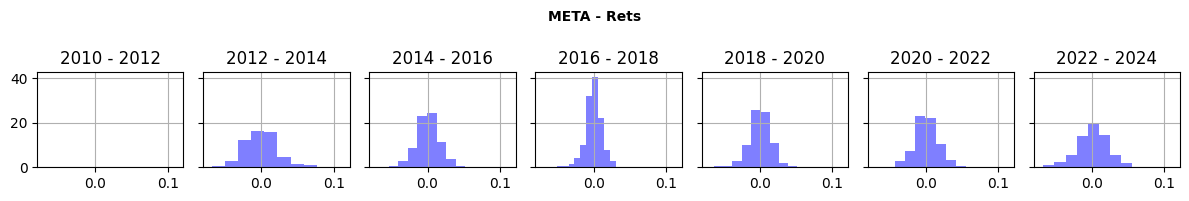

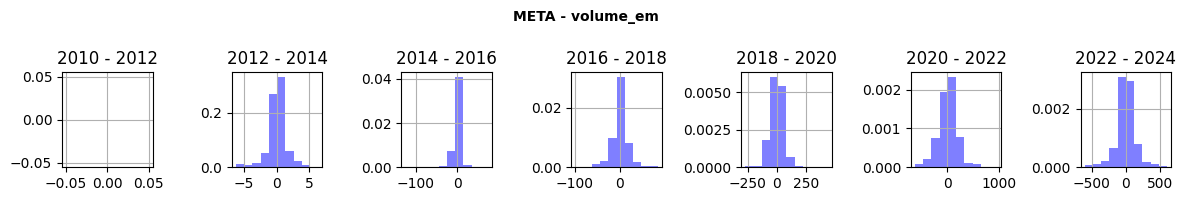

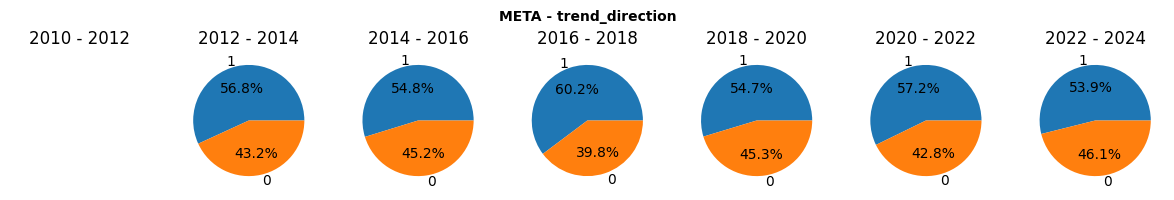

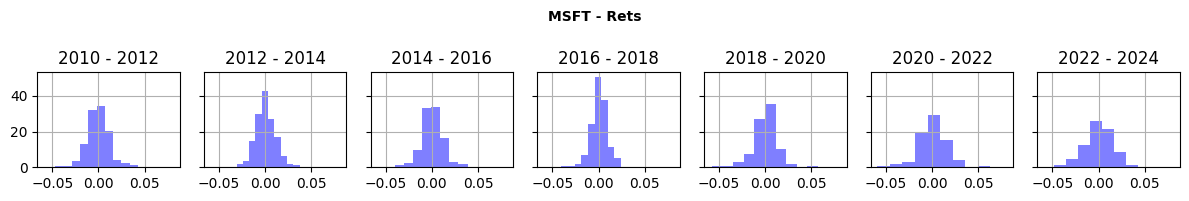

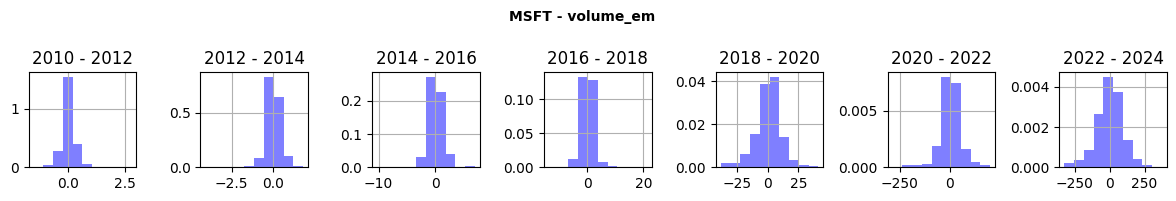

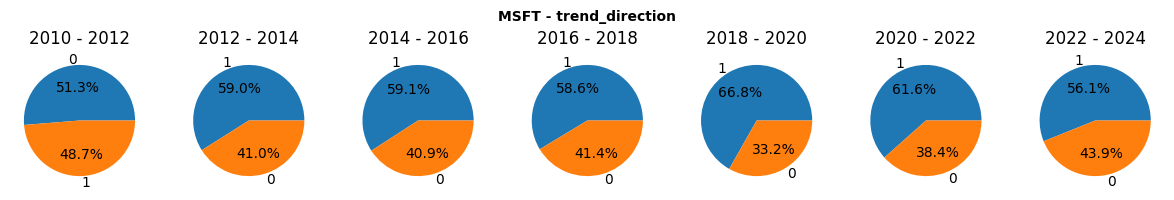

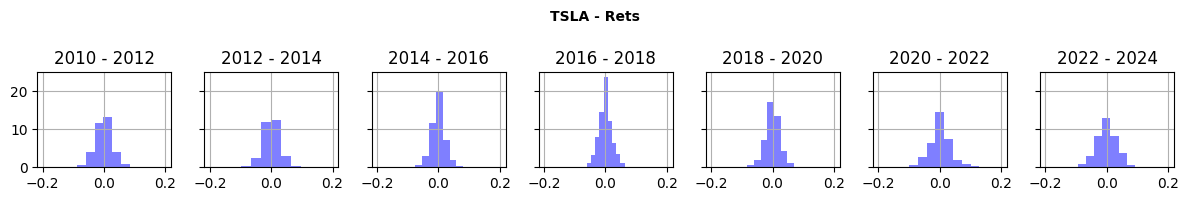

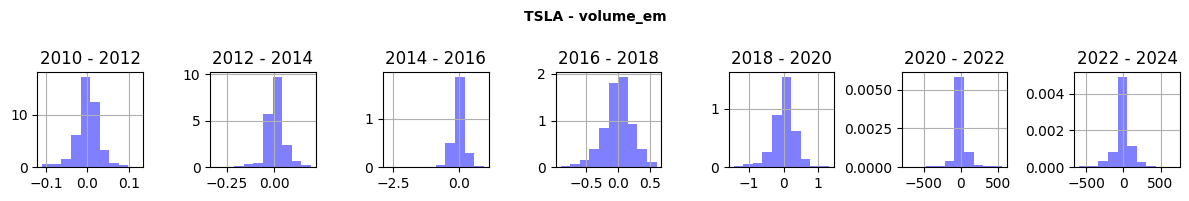

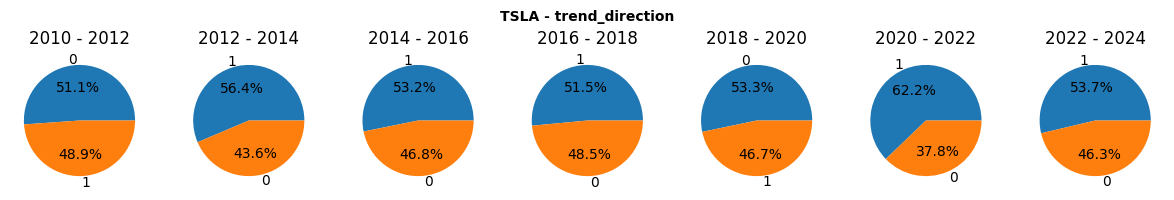

In [17]:
for s in symbols:
    df = pd.read_parquet(f'data/final_{s}.parquet')
    df['Date'] = [str(v) for v in pd.to_datetime(df['Date'])]
    for c in ['Rets', 'volume_em', 'trend_direction']:
        fig, axes = plt.subplots(ncols=7, figsize=(12, 2), sharey=False if c == 'volume_em' else 'all', sharex=False if c == 'volume_em' else 'all')
        # fig, axes = plt.subplots(ncols=7, figsize=(12, 2), sharey='all', sharex='all')
        i = 0
        for year in range(2010, 2024, 2):
            aux = df[(df['Date'] > str(year)) & (df['Date'] < str(year + 2))]
            if c == 'trend_direction':
                axes[i].pie(aux[c].value_counts(), labels=aux[c].value_counts().index, autopct='%1.1f%%')
            else:
                axes[i].hist(aux[c], alpha=0.5, color='blue', density=True, bins=10, label=f'{year}-{year+2}')
                axes[i].grid()
            axes[i].set_title(f'{year} - {year+2}')
            i += 1
        fig.suptitle(f'{s} - {c}', fontsize=10, fontweight='bold')
        plt.tight_layout()
        plt.show()

Vemos que en general las distribuciones son similares para todas las ventanas para las variables ***Rets y trend_direction***. Para Rets es muy similar en todas las ventanas a excepción de la ventana entre 2016 y 2018 donde la distribución se hace más puntiaguada en el 0. 

Sin embargo la variable ***volume_em*** es muy distinta dependiendo de la ventana, de hecho es tan distinta que no hemos podido hacer que los gráficos compartan ejes ya que no se apreciaban los datos en ese caso. Si nos fijamos en la escala de los ejes y y ejes x de los histogramas de la variable volume_em nos damos cuenta de que son completamente distintos dependiendo de la ventana lo que nos indica que hay mucha deriva.

Ahora analizaremos la deriva en la variable respuesta

Primero analizaremos los datos antiguos frente a los nuevos

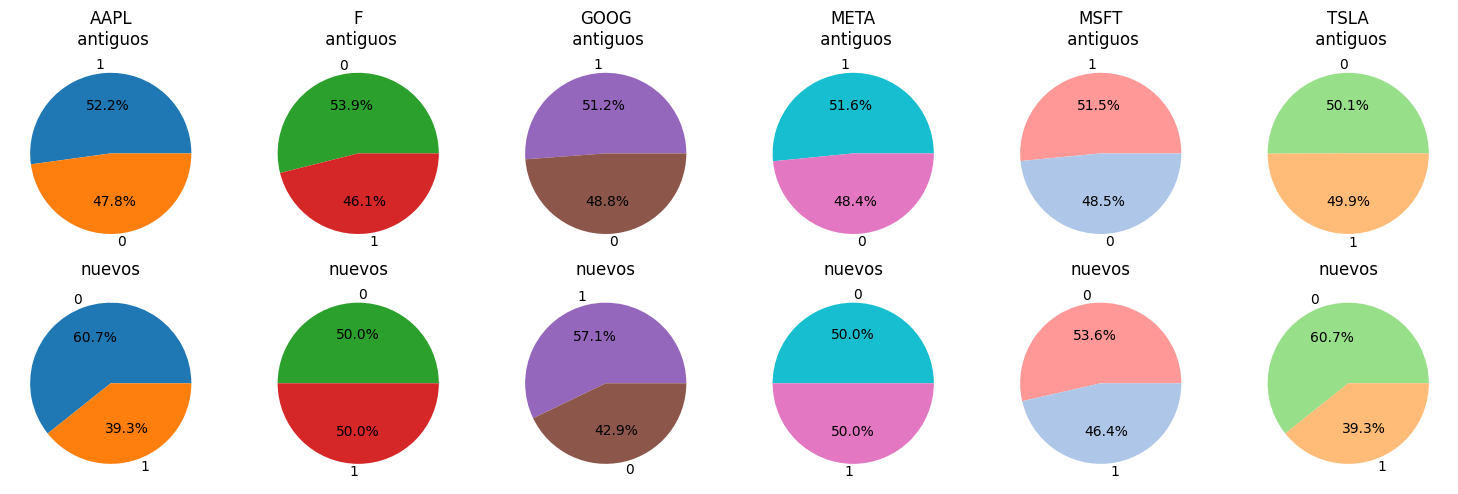

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(15, 5))
i = 0
colors = [['#1f77b4', '#ff7f0e'], ['#2ca02c', '#d62728'], ['#9467bd', '#8c564b'], ['#17becf', '#e377c2'], ['#ff9896', '#aec7e8'], ['#98df8a', '#ffbb78']]
for s in symbols:
    df = pd.read_parquet(f'data/final_{s}.parquet')
    df_nuevo = pd.read_parquet(f'data/final_test_{s}.parquet')
    axes[0, i].pie(df['Invest'].value_counts(), labels=df['Invest'].value_counts().index, autopct='%1.1f%%', colors=colors[i])
    axes[1, i].pie(df_nuevo['Invest'].value_counts(), labels=df_nuevo['Invest'].value_counts().index, autopct='%1.1f%%', colors=colors[i])
    axes[0, i].set_title(f'{s}\n antiguos')
    axes[1, i].set_title('nuevos')
    i += 1
plt.tight_layout()
plt.show()

Vamos a analizar ahora la variable respuesta en ventanas temporales de 2 años.

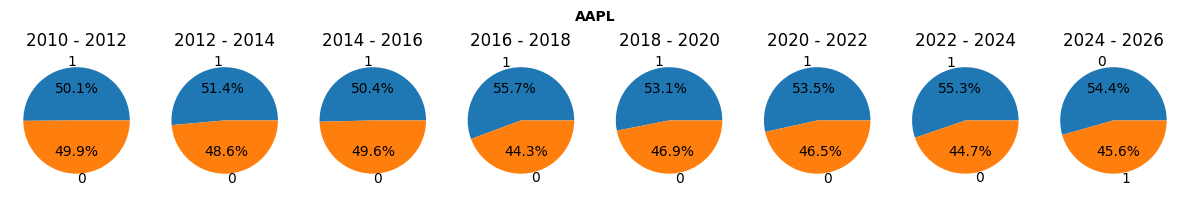

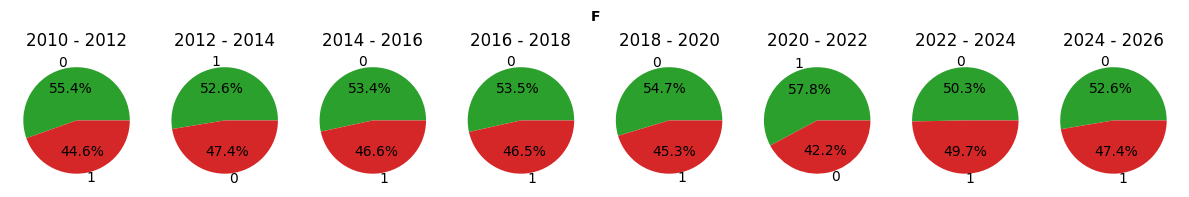

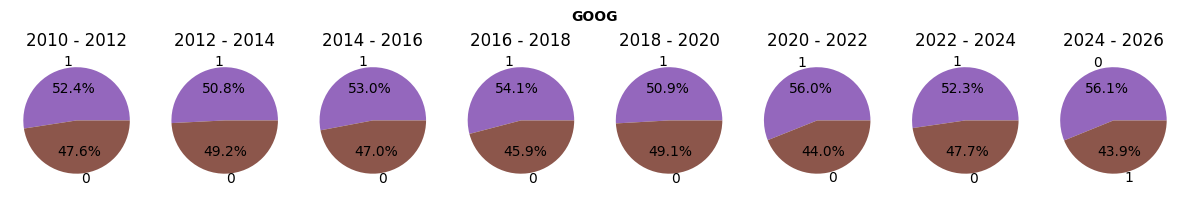

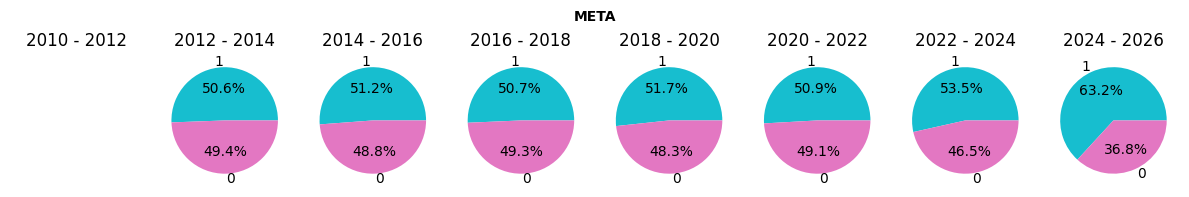

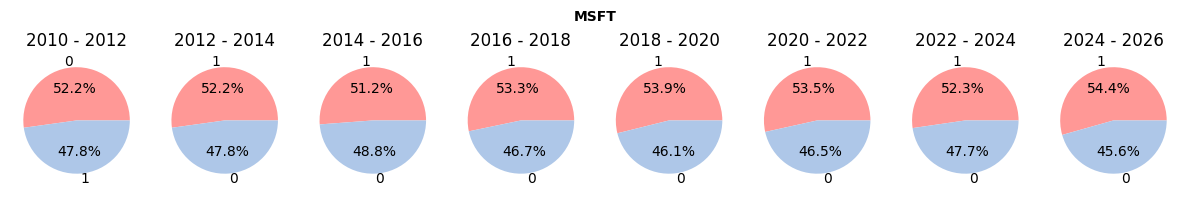

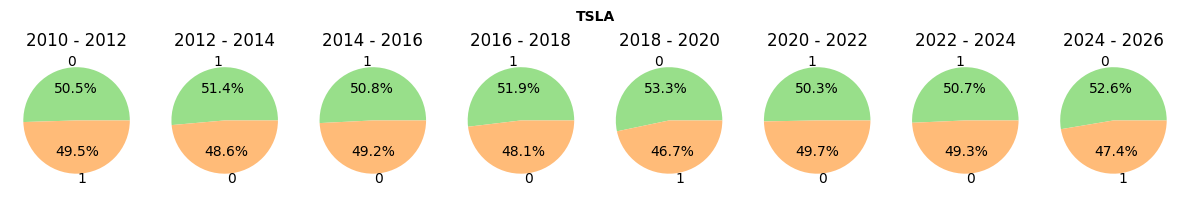

In [19]:
colors = [['#1f77b4', '#ff7f0e'], ['#2ca02c', '#d62728'], ['#9467bd', '#8c564b'], ['#17becf', '#e377c2'], ['#ff9896', '#aec7e8'], ['#98df8a', '#ffbb78']]
j = 0
for s in symbols:
    df = pd.read_parquet(f'data/final_{s}.parquet')
    df['Date'] = [str(v) for v in pd.to_datetime(df['Date'])]
    fig, axes = plt.subplots(ncols=8, figsize=(12, 2))
    i = 0
    for year in range(2010, 2025, 2):
        aux = df[(df['Date'] > str(year)) & (df['Date'] < str(year + 2))]
        axes[i].pie(aux['Invest'].value_counts(), labels=aux[c].value_counts().index, autopct='%1.1f%%', colors=colors[j])
        axes[i].set_title(f'{year} - {year+2}')
        i += 1
    fig.suptitle(f'{s}', fontsize=10, fontweight='bold')
    plt.tight_layout()
    plt.show()
    j += 1

# REENTRENAMIENTO Y EVALUACIÓN

In [23]:
RANDOM_STATE = 42
best_models = {
        'AAPL': {'clf': MLPClassifier(activation='relu', alpha=0.001, batch_size=200, hidden_layer_sizes=(100, 100, 100),
                                      max_iter=50,
                                      early_stopping=True, random_state=RANDOM_STATE),
                 'cols': ['Ret_3', 'VMA20', 'VMA_3ªsem', 'volatility_ui', 'trend_kst_diff', 'trend_adx', 'trend_aroon_up',
                          'momentum_pvo', 'others_dlr', 'volatility_bbli', 'volatility_kcli'],
                 'add_ft_sq': False,
                 'trans_data': True,
                 'scaler': MinMaxScaler(),
                 'cols_to_scale': 'continuous',
                 },
        'F': {'clf': LogisticRegression(C=0.01, penalty='l2', solver='liblinear',
                                        class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE),
              'cols': ['Rets', 'Ret_1', 'VMA20', 'VMA60', 'VMA_1ªsem', 'VMA_3ªsem', 'volume_em', 'volume_vpt',
                       'volatility_dcl', 'volatility_dcw', 'volatility_atr', 'trend_adx_pos', 'trend_visual_ichimoku_b',
                       'trend_aroon_down', 'trend_aroon_ind', 'momentum_uo', 'volatility_bbhi', 'volatility_bbli',
                       'trend_psar_up_indicator', 'trend_direction'],
              'add_ft_sq': False,
              'trans_data': True,
              'scaler': PowerTransformer(),
              'cols_to_scale': 'continuous',
              },
        'GOOG': {'clf': RandomForestClassifier(criterion='entropy', max_depth=10, max_features=10, min_samples_leaf=1,
                                               n_estimators=30,
                                               class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE),
                 'cols': ['Rets', 'Ret_1', 'Ret_2', 'Ret_3', 'VMA20', 'VMA60', 'VMA_2ªsem', 'VMA_4ªsem', 'VMA_5ªsem',
                          'volume_cmf', 'volume_em', 'volume_vpt', 'volatility_kcw', 'volatility_ui', 'trend_dpo',
                          'trend_adx', 'momentum_pvo', 'others_dlr'],
                 'add_ft_sq': False,
                 'trans_data': False,
                 'scaler': None,
                 'cols_to_scale': None,
                 },
        'META': {'clf': RandomForestClassifier(criterion='entropy', max_depth=50, max_features=15, min_samples_leaf=10,
                                               n_estimators=30,
                                               class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE),
                 'cols': ['Ret_2', 'volume_fi', 'volume_sma_em', 'volatility_dcw', 'trend_aroon_ind', 'momentum_ppo_hist',
                          'Rets^2', 'Ret_3^2', 'VMA40^2', 'VMA_5ªsem^2', 'volume_cmf^2', 'volume_em^2', 'volume_sma_em^2',
                          'volatility_dcw^2', 'momentum_ppo_hist^2', 'momentum_pvo_signal^2'],
                 'add_ft_sq': True,
                 'trans_data': False,
                 'scaler': None,
                 'cols_to_scale': None,
                 },
        'MSFT': {'clf': RandomForestClassifier(criterion='gini', max_depth=10, max_features='sqrt', min_samples_leaf=1,
                                               n_estimators=100,
                                               class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE),
                 'cols': ['VMA_2ªsem', 'volume_em', 'trend_adx_neg'],
                 'add_ft_sq': False,
                 'trans_data': False,
                 'scaler': None,
                 'cols_to_scale': None,
                 },
        'TSLA': {'clf': LogisticRegression(C=0.001, penalty=None, solver='lbfgs',
                                           class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE),
                 'cols': ['Open', 'High', 'trend_psar_down_indicator', 'momentum_ppo_hist', 'Sent', 'trend_direction'],
                 'add_ft_sq': False,
                 'trans_data': True,
                 'scaler': StandardScaler(),
                 'cols_to_scale': 'big',
                 },
    }

In [41]:
def get_data_retrain(symbol):
    df_train = pd.read_parquet(Path(Path.cwd(), f'data/final_{symbol}.parquet'))
    df_test = pd.read_parquet(Path(Path.cwd(), f'data/final_test_{symbol}.parquet'))
    return df_train, df_test


def get_tomorrow_rets(train, test):
    tomorrow_rets_train = e.get_tomorrow_rets(train)
    tomorrow_rets_test = e.get_tomorrow_rets(test)
    return pd.concat([tomorrow_rets_train, tomorrow_rets_test])

def transform_data(train, test, columns_scale, scaler=StandardScaler()):
    columns_scale = [c for c in columns_scale if c in train.columns]
    other_cols = [c for c in train.columns if c not in columns_scale]
    train_scaled = pd.DataFrame(scaler.fit_transform(train[columns_scale]), columns=columns_scale, index=train.index)
    test_scaled = pd.DataFrame(scaler.transform(test[columns_scale]), columns=columns_scale, index=test.index)
    return (pd.concat([train_scaled, train[other_cols]], axis=1),
            pd.concat([test_scaled, test[other_cols]], axis=1))
    
def preparar_datos(train, test, params):    
    train = p.df_to_numeric(train)
    test = p.df_to_numeric(test)
    
    if params['add_ft_sq']:
        train = p.add_features_squared(train)
        test = p.add_features_squared(test)
    
    x_train, y_train = train.drop('Invest', axis=1), train['Invest']
    x_test, y_test = test.drop('Invest', axis=1), test['Invest']
    if params['trans_data']:
        cols_scale = p.get_columns_to_scale(x_train, params['cols_to_scale'])
        x_train, x_test = transform_data(x_train, x_test, cols_scale, params['scaler'])
    x_train, x_test = x_train.loc[:, params['cols']], x_test.loc[:, params['cols']]
    return x_train, x_test, y_train, y_test

In [48]:
def evaluar(clf, x_train, x_test, y_train, y_test, tomorrow_rets, train_size=.8, ax=None):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print('Accuracy:', round(accuracy_score(y_test, y_pred), 5))
    print('Balanced accuracy:', round(balanced_accuracy_score(y_test, y_pred), 5))
    print('Recall:', round(recall_score(y_test, y_pred), 5))
    print('Precision:', round(precision_score(y_test, y_pred), 5))
    print('Rendimiento strat:', e.score_rendimiento(y_test, y_pred, tomorrow_rets=tomorrow_rets))
    print('Matriz de confusión en test:\n', confusion_matrix(y_test, y_pred))
    e.show_plot(y_pred, tomorrow_rets.loc[y_test.index], ax)


##########################               AAPL               ##########################
Accuracy: 0.71429
Balanced accuracy: 0.66845
Recall: 0.45455
Precision: 0.71429
Rendimiento strat: 1.0569663392628974
Matriz de confusión en test:
 [[15  2]
 [ 6  5]]
STOCK RETURN: 0.007475396808993562
STRAT_RETURN: 0.0569663392628974

##########################               F               ##########################
Accuracy: 0.46429
Balanced accuracy: 0.46429
Recall: 0.85714
Precision: 0.48
Rendimiento strat: 0.9488997441581373
Matriz de confusión en test:
 [[ 1 13]
 [ 2 12]]
STOCK RETURN: -0.05259269046281323
STRAT_RETURN: -0.05110025584186273

##########################               GOOG               ##########################
Accuracy: 0.71429
Balanced accuracy: 0.6875
Recall: 0.875
Precision: 0.7
Rendimiento strat: 1.0889302235551719
Matriz de confusión en test:
 [[ 6  6]
 [ 2 14]]
STOCK RETURN: 0.06701119357976837
STRAT_RETURN: 0.08893022355517188

##########################               

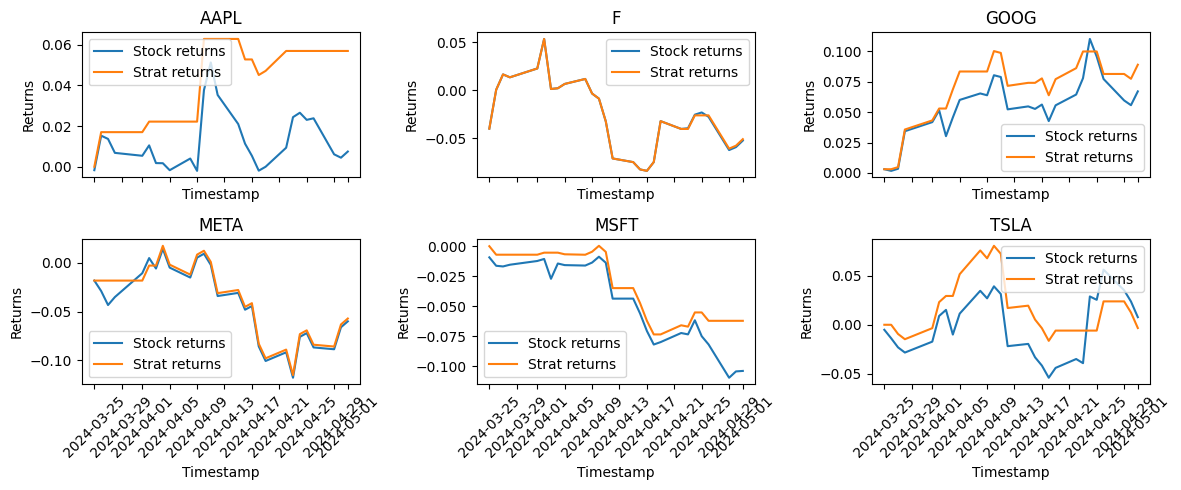

In [57]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 5), sharex='all')
i, j = 0, 0
for s in symbols:
    df_train, df_test = get_data_retrain(s)
    tomorrow_rets = get_tomorrow_rets(df_train, df_test)
    
    x_train, x_test, y_train, y_test = preparar_datos(df_train, df_test, best_models[s])

    print('\n##########################              ', s, '              ##########################')
    evaluar(best_models[s]['clf'], x_train, x_test, y_train, y_test, tomorrow_rets, ax=axes[i, j])
    axes[i, j].set_title(s)
    j += 1
    if j == 3:
        i += 1
        j = 0
plt.tight_layout()
plt.show()

#### ANALISIS DE LA MEDIA DE GANANCIAS Y PÉRDIDAS SI SE INVIERTE O NO


##########################               AAPL               ##########################
Media de dinero ganado cuando se invierte y se acierta: 0.015
Media de dinero perdido cuando se invierte y se falla: -0.008
Media de dinero que se podía haber ganado: 0.007
Media de dinero salvado al no invertir: -0.006


##########################               F               ##########################
Media de dinero ganado cuando se invierte y se acierta: 0.016
Media de dinero perdido cuando se invierte y se falla: -0.02
Media de dinero que se podía haber ganado: 0.002
Media de dinero salvado al no invertir: -0.005


##########################               GOOG               ##########################
Media de dinero ganado cuando se invierte y se acierta: 0.01
Media de dinero perdido cuando se invierte y se falla: -0.012
Media de dinero que se podía haber ganado: 0.017
Media de dinero salvado al no invertir: -0.009


##########################               META               #################

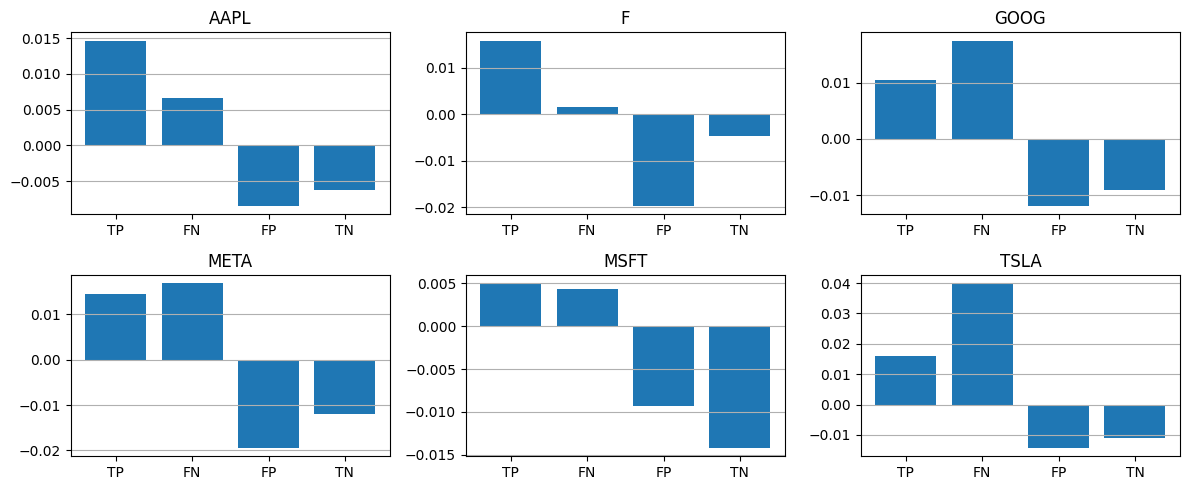

In [64]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 5))
i, j = 0, 0
for s in symbols:
    df_train, df_test = get_data_retrain(s)
    tomorrow_rets = get_tomorrow_rets(df_train, df_test)
    
    x_train, x_test, y_train, y_test = preparar_datos(df_train, df_test, best_models[s])

    print('\n##########################              ', s, '              ##########################')
    
    best_models[s]['clf'].fit(x_train, y_train)
    y_pred = best_models[s]['clf'].predict(x_test)
    
    aux_tmrw_rets = tomorrow_rets.loc[x_test.index]
    tp, tn, fp, fn = (aux_tmrw_rets[(y_pred == 1) & (aux_tmrw_rets > 0)],
                      aux_tmrw_rets[(y_pred == 0) & (aux_tmrw_rets < 0)],
                      aux_tmrw_rets[(y_pred == 1) & (aux_tmrw_rets < 0)],
                      aux_tmrw_rets[(y_pred == 0) & (aux_tmrw_rets > 0)])
    print('Media de dinero ganado cuando se invierte y se acierta:', round(tp.mean(), 3))
    print('Media de dinero perdido cuando se invierte y se falla:', round(fp.mean(), 3))
    print('Media de dinero que se podía haber ganado:', round(fn.mean(), 3))
    print('Media de dinero salvado al no invertir:', round(tn.mean(), 3))
    print()
    axes[i, j].bar(x=['TP', 'FN', 'FP', 'TN'], height=[tp.mean(), fn.mean(), fp.mean(), tn.mean()])
    axes[i, j].grid(True, axis='y')
    axes[i, j].set_title(s)
    j += 1
    if j == 3:
        j = 0
        i += 1
plt.tight_layout()
plt.show()